# Project Phase 2 - Age Predictor using Regression Model
# Muhammad Shahab Alam 21i-1915 


         pitch  formants  intensity  duration  spectral_centroid  \
0    -0.309663  1.125525  -1.107670  1.019426          -0.827309   
1    -1.246551 -1.235015  -0.869670 -1.314580           0.172538   
2    -1.454749  0.200644  -0.195329  0.104941          -0.782641   
3    -0.379063  0.776086  -0.364681  0.760086          -0.798294   
4     0.280229 -0.115980   0.008063 -0.181713          -0.686304   
...        ...       ...        ...       ...                ...   
5610  0.141431  2.024165  -0.895146  1.947581           0.319635   
5611 -0.274964  1.555698  -0.600151  1.510791           0.615591   
5612 -0.968955 -0.529641   0.827754 -0.577519          -1.190636   
5613 -1.350650  0.335348   0.866245  0.377924           0.902425   
5614 -0.968955 -0.519416   0.942951 -0.099797          -0.069232   

      spectral_bandwidth  spectral_contrast  age  
0              -0.361215           0.807584   25  
1              -0.265594          -0.146997   75  
2              -1.636857      

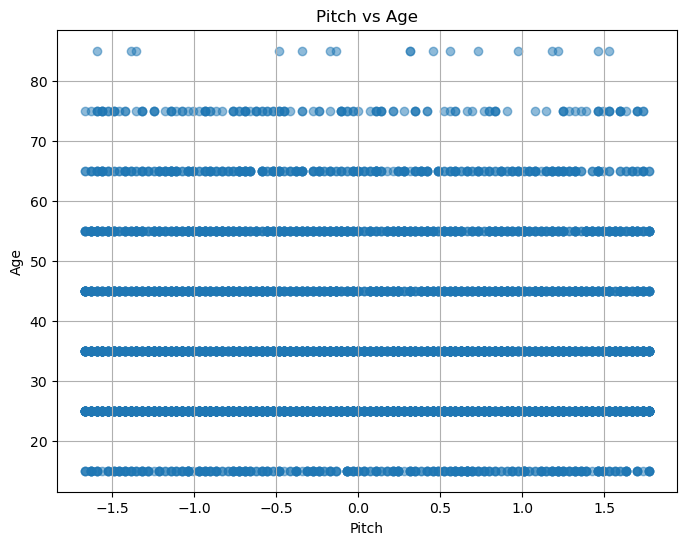

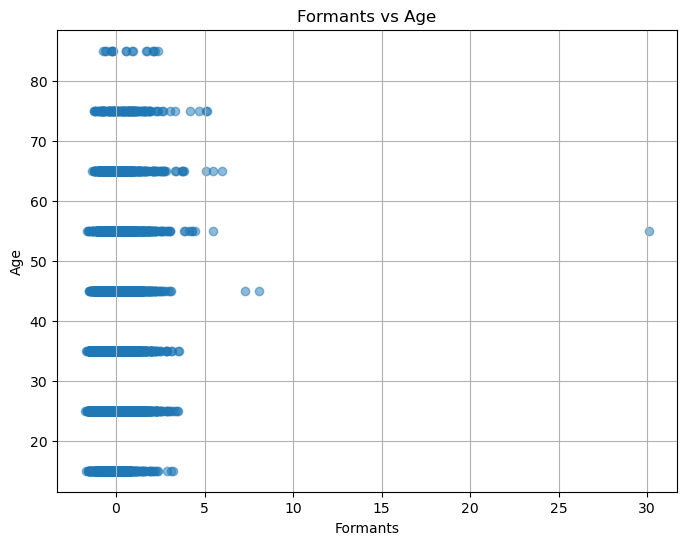

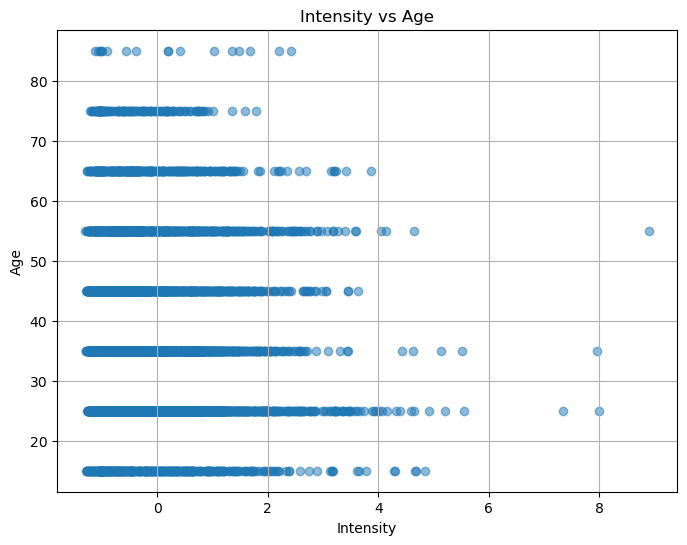

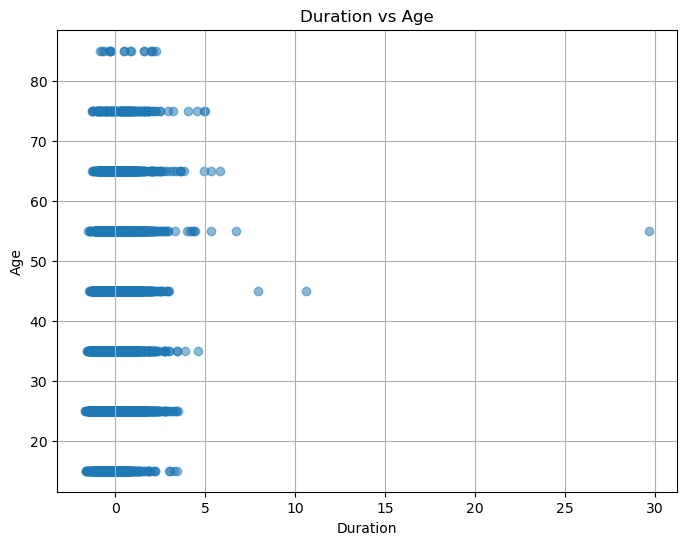

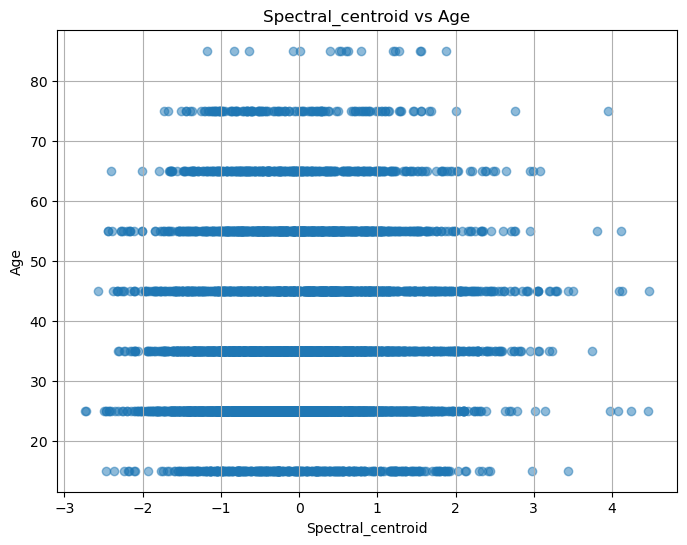

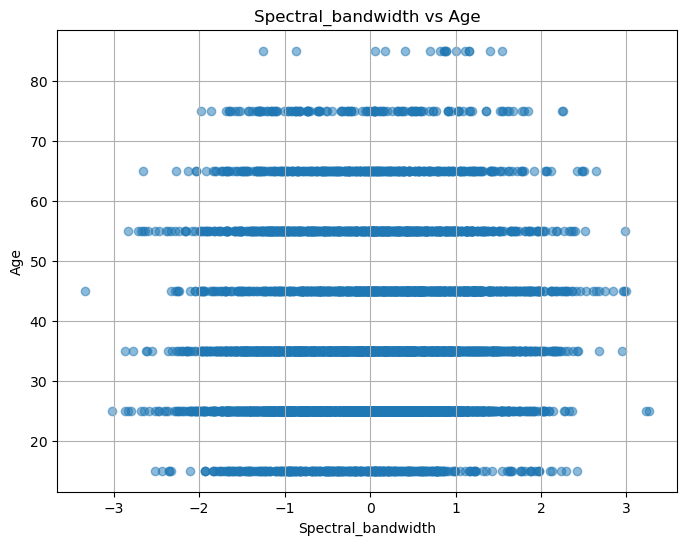

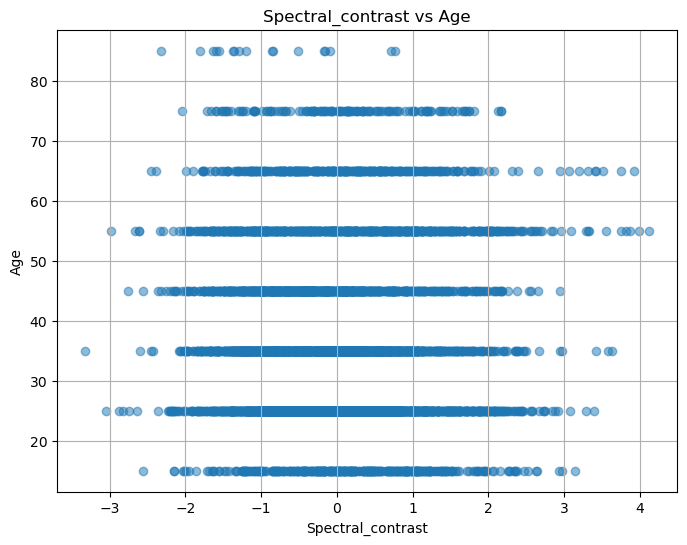

In [3]:
import librosa
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


class LinearRegressionCustom:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]  # Add a column of ones for the intercept term
        self.coef_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]
        
    def predict(self, X):
        return X.dot(self.coef_) + self.intercept_


def extract_features(file_path):
    y, sr = librosa.load(file_path)
    pitch = librosa.pitch_tuning(y)
    trimmed_y, _ = librosa.effects.trim(y)
    formants = len(trimmed_y)
    intensity = np.mean(librosa.feature.rms(y=y))
    duration = librosa.get_duration(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    
    features = {
        'pitch': pitch,
        'formants': formants,
        'intensity': intensity,
        'duration': duration,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_contrast': spectral_contrast
    }
    
    return features
    
# to convert age values to numeric
# midpoint of the values
# for eg if twenties 20-29 return 25
def age_to_numeric(age_str):
    if age_str == 'teens':
        return 15
    elif age_str == 'twenties':
        return 25
    elif age_str == 'thirties':
        return 35
    elif age_str == 'fourties':
        return 45
    elif age_str == 'fifties':
        return 55
    elif age_str == 'sixties':
        return 65
    elif age_str == 'seventies':
        return 75
    elif age_str == 'eighties':
        return 85
    else:
        return None

# Loading the dataset
data_path = '/Users/mbp/Desktop/untitled folder/Dataset'
csv_file = 'truncated_train.csv'
df = pd.read_csv(os.path.join(data_path, csv_file))

# Initialize lists to store features and ages
feature_list = []
age_list = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # accessing the age col
    age_str = row.iloc[4]
    # converting from words to numeric
    age = age_to_numeric(age_str)
    if age is not None:
        file_path = os.path.join(data_path, row.iloc[0])
        try:
            features = extract_features(file_path)
            feature_list.append(features)
            age_list.append(age)
        except FileNotFoundError:
            pass

# Convert feature_list to DataFrame
features_df = pd.DataFrame(feature_list)

# Normalize the audio features
normalized_features = (features_df - features_df.mean()) / features_df.std()

# Convert age_list to DataFrame
age_df = pd.DataFrame(age_list, columns=['age'])

# Concatenate normalized audio features and age DataFrame
normalized_df = pd.concat([normalized_features, age_df], axis=1)

# Print the normalized DataFrame
print(normalized_df)
for column in normalized_df.columns[:-1]:  # Exclude the last column which is the target variable 'age'
    plt.figure(figsize=(8, 6))
    plt.scatter(normalized_df[column], normalized_df['age'], alpha=0.5)
    plt.title(f'{column.capitalize()} vs Age')
    plt.xlabel(column.capitalize())
    plt.ylabel('Age')
    plt.grid(True)
    plt.show()

# Extract features and target variable
X = normalized_df.drop(columns=['age'])  # Features
y = normalized_df['age']  # Target variable

# Initialize and train the custom linear regression model
model_custom = LinearRegressionCustom()
model_custom.fit(X.values, y.values)

# Predict the age labels for the entire dataset
y_pred_custom = model_custom.predict(X.values)


In [4]:
# Load the testing dataset
csv_file_test = 'cv-valid-test.csv'
df_test = pd.read_csv(os.path.join(data_path, csv_file_test))

# Initialize lists to store features and ages for testing data
feature_list_test = []
age_list_test = []

# Iterate over each row in the testing DataFrame
for index, row in df_test.iterrows():
    age_str = row.iloc[4]
    age = age_to_numeric(age_str)
    if age is not None:
        file_path = os.path.join(data_path, row.iloc[0])
        try:
            features = extract_features(file_path)
            feature_list_test.append(features)
            age_list_test.append(age)
        except FileNotFoundError:
            pass

# Convert feature_list_test to DataFrame
features_df_test = pd.DataFrame(feature_list_test)

# Normalize the audio features for testing data
normalized_features_test = (features_df_test - features_df.mean()) / features_df.std()

# Convert age_list_test to DataFrame
age_df_test = pd.DataFrame(age_list_test, columns=['actual_age'])

# Concatenate normalized audio features and actual age DataFrame for testing data
normalized_df_test = pd.concat([normalized_features_test, age_df_test], axis=1)

# Predict the age labels for the testing data
y_pred_test_custom = model_custom.predict(normalized_features_test.values)

# Create a DataFrame for predicted ages
predicted_df_custom = pd.DataFrame({'predicted_age_custom': y_pred_test_custom})

# Concatenate the predicted ages DataFrame with the actual ages DataFrame
result_df_custom = pd.concat([predicted_df_custom, age_df_test], axis=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate mean squared error (MSE) for testing data
mse_test = mean_squared_error(result_df_custom['actual_age'], result_df_custom['predicted_age_custom'])
print("Mean Squared Error on testing data:", mse_test)

# Calculate mean absolute error (MAE) for testing data
mae_test = mean_absolute_error(result_df_custom['actual_age'], result_df_custom['predicted_age_custom'])
print("Mean Absolute Error on testing data:", mae_test)

# Calculate R-squared (R^2) coefficient of determination for testing data
r2_test = r2_score(result_df_custom['actual_age'], result_df_custom['predicted_age_custom'])
print("R-squared (R^2) coefficient of determination on testing data:", r2_test)


# Save the predicted and actual ages to a CSV file
result_df_custom.to_csv('predicted_vs_actual_custom.csv', index=False)

Mean Squared Error on testing data: 212.84792180232202
Mean Absolute Error on testing data: 11.938882808398604
R-squared (R^2) coefficient of determination on testing data: 0.031780970421948496
